In [1]:
using Random, PyPlot, ProgressMeter
using PyPlot: matplotlib
rc("font", family="Arial")

In [2]:
using Statistics

ToDo: dimsをv, wで修正

In [3]:
function plot_som(v, w; vcolor="tab:blue")
    num_w, dims = size(w)
    num_w_sqrt = Int(sqrt(num_w))
    rw = reshape(w, (num_w_sqrt, num_w_sqrt, dims))
    scatter(v[:, 1], v[:, 2], s=10, color=vcolor)
    plot(rw[:, :, 1], rw[:, :, 2], "k", alpha=0.5); 
    plot(rw[:, :, 1]', rw[:, :, 2]', "k", alpha=0.5)
    scatter(w[:, 1], w[:, 2], s=5, fc="white", ec="k", zorder=99) # w[i, j, 1]とw[i, j, 2]の点をプロット
end;

近傍関数 (neighborhood function)のための二次元ガウス関数を実装する．Winnerニューロンからの距離に応じて値が減弱する関数である．ここでは一つの入力に対して全てのニューロンの活動ベクトルを更新するということはせず，winner neuronの近傍のニューロンのみ更新を行う．つまり，更新においてはglobalではなくlocalな処理のみを行うということである  (Winner neuronの決定にはWTAによるglobalな評価が必要ではあるが) ．

自己組織化マップのメインとなる関数を書く．ナイーブに実装する．この方法だと空間が円，球体やトーラスのように周期性を持つ場合にも適応できる．

In [4]:
# Gaussian mask for inputs
function gaussian_mask(sizex=9, sizey=9; σ=5)
    x, y = 0:sizex-1, 0:sizey-1
    X, Y = ones(sizey) * x', y * ones(sizex)' 
    x0, y0 = (sizex-1) / 2, (sizey-1) / 2
    mask = exp.(-((X .- x0) .^2 + (Y .- y0) .^2) / (2.0(σ^2)))
    return mask ./ sum(mask)
end;

In [5]:
function som_2d(v, init_w; α0=1.0, σ0=6, T=500, return_history=true)
    # α0: update rate, σ0 : width, T : training steps
    w = copy(init_w)
    num_w, dims = size(init_w)
    num_w_sqrt = Int(sqrt(num_w))
    num_v = size(v)[1]
    
    w_history = [copy(w)] # history of w
    
    w_2d = reshape(w, (num_w_sqrt, num_w_sqrt, dims))
    
    if return_history
        w_history = [copy(init_w)] # history of w
    end
    
    @showprogress for t in 1:T
        α = α0 * (1 - t/T); # update rate
        σ = max(σ0 * (1 - t/T), 1); # decay from large to small (linearly decreased, avoid zero)
        wm = ceil(Int, σ)
        h = gaussian_mask(2wm+1, 2wm+1, σ=σ);
        # loop for the num_v inputs
        for i in 1:num_v
            dist = sum([(v[i, j] .- w_2d[:, :, j]).^2 for j in 1:dims]) # distance between input and neurons
            win_idx = argmin(dist) # winner index
            idx = [max(1,win_idx[j] - wm):min(num_w_sqrt, win_idx[j] + wm) for j in 1:2] # neighbor indices
            # update the winner & neighbor neuron
            η = α * h[1:length(idx[1]), 1:length(idx[2])]
            for j in 1:dims
                w_2d[idx..., j] += η .* (v[i, j] .- w_2d[idx..., j])
            end
        end
        if return_history
            w = reshape(w_2d, (num_w, dims))
            append!(w_history, [copy(w)]) # save w
        end
    end
    if return_history
        return w_history
    else
        w = reshape(w_2d, (num_w, dims))
        return w
    end
end;

## 視覚野マップ
集合の直積を配列として返す関数 `product`と極座標を直交座標に変換する関数 `pol2cart`を用意する．

In [6]:
product(sets...) = hcat([collect(x) for x in Iterators.product(sets...)]...)' # Array of Cartesian product of sets 
pol2cart(θ, r) = r*[cos(θ), sin(θ)];

刺激と初期の活動ベクトルは{cite:p}`Carreira-Perpinan2005-gy`　を参考に作成．直積`product`で全ての組の入力を作成する．

In [19]:
# generate stimulus
Random.seed!(1234);
Nx, Ny, NOD, NOR = 10, 10, 2, 6
dims = 4  # dims of inputs 
l, r = 0.14, 0.17

rx, ry = range(0, 1, length=Nx), range(0, 1, length=Ny)
rOD = range(-l, l, length=NOD)
#rORθ = range(-π, π, length=NOR+1)[1:end-1]
#rORθ = range(0, π, length=NOR+1)[1:end-1]
#rORθ = range(0, π, length=NOR+1)[1:end-1]
rORθ = range(-π/2, π/2, length=NOR+1)[1:end-1]

# stimuli
v = product(rx, ry, rOD, rORθ);
rORxy = r .* cos.(v[:, 4]);
#rORxy = hcat(pol2cart.(v[:, 3], v[:, 4])...)
#v = product(rx, ry, rOD, rORθ, r);
#rORxy = hcat(pol2cart.(2v[:, 4], v[:, 5])...)
#rORxy = hcat(pol2cart.(2v[:, 4], v[:, 5])...)

In [20]:
v[:, 4] = rORxy;
#v += (rand(size(v)...) .- 1) * 1e-5;

In [9]:
#mean_v = mean(v, dims=1)
#std_v = std(v, dims=1)
#v2 = (v .- mean_v) ./ std_v;

In [21]:
# initial neurons
num_w_sqrt = 64
num_w = num_w_sqrt^2
#init_w = randn(num_w, 5);
init_w = product(range(0, 1, length=num_w_sqrt), range(0, 1, length=num_w_sqrt))
init_w += (rand(size(init_w)...) .- 1) * 0.05;
#init_w = [init_w hcat(pol2cart.(π*(rand(num_w) .- 0.5), r*rand(num_w))...)'];
init_w = [init_w 2l*(rand(num_w) .- 0.5) rand(num_w)];
#init_w = [init_w 2l*(rand(num_w) .- 0.5) hcat(pol2cart.(2π*(rand(num_w) .- 0.5), r*rand(num_w)...)'];

https://www.sciencedirect.com/science/article/pii/S0960982220317383

In [22]:
w = som_2d(v, init_w, α0=1.5, σ0=5.0, T=50, return_history=false); # faster
#w = som(v, init_w, α0=1.5, σ0=5.0, T=50, return_history=false);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


In [12]:
#w2 = w .* std_v .+ mean_v;

In [28]:
num_w, dims = size(w)
num_w_sqrt = Int(sqrt(num_w))
rw = reshape(w, (num_w_sqrt, num_w_sqrt, dims))
ORmap = acos.(rw[:, :, 4]); # get angle of polar 
#ORmap = atan.(rw[:, :, 4], rw[:, :, 3]); # get angle of polar 

In [25]:
maximum(rw[:, :, 4])

0.46391997502627647

In [26]:
minimum(rw[:, :, 4])

0.011729138605265386

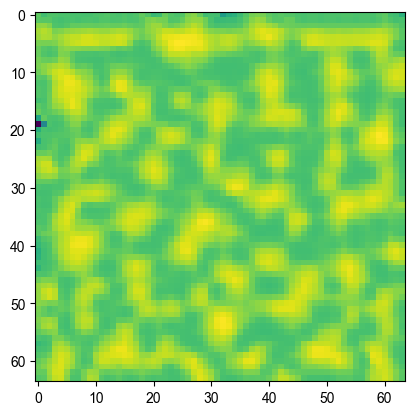

PyObject <matplotlib.image.AxesImage object at 0x00000227CBCD12B0>

In [29]:
imshow(ORmap)#, cmap="hsv", origin="lower")

描画用関数を実装する． `w_history`を用いてアニメーションを作成すると発達の過程が可視化されるが，これは読者への課題とする．

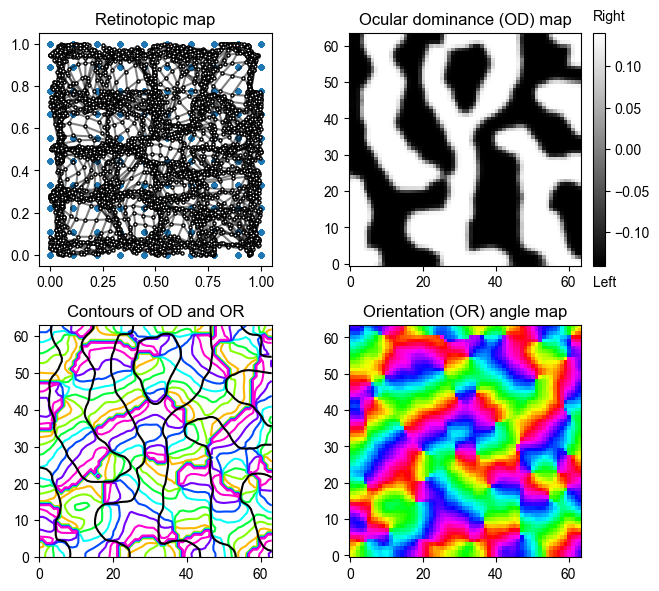

In [27]:
figure(figsize=(7, 6))
subplot(2,2,1, adjustable="box", aspect=1); title("Retinotopic map")
plot_som(v, w)

num_w, dims = size(w)
num_w_sqrt = Int(sqrt(num_w))
rw = reshape(w, (num_w_sqrt, num_w_sqrt, dims))

ax1 = subplot(2,2,2, adjustable="box", aspect=1); title("Ocular dominance (OD) map")
imshow(rw[:, :, 3], cmap="gray", origin="lower") 

ins1 = ax1.inset_axes([1.05,0,0.05,1])
colorbar(cax=ins1, aspect=40, pad=0.08, shrink=0.6)
ins1.text(0, -0.16, "Left", ha="left", va="center")
ins1.text(0, 0.16, "Right", ha="left", va="center")

subplot(2,2,3, adjustable="box", aspect=1); title("Contours of OD and OR")
ORmap = atan.(rw[:, :, 5], rw[:, :, 4]); # get angle of polar 
sizex, sizey = num_w_sqrt, num_w_sqrt
x, y = 0:sizex-1, 0:sizey-1
X, Y = ones(sizey) * x', y * ones(sizex)';
contour(X, Y, ORmap, cmap="hsv")
contour(X, Y, rw[:, :, 3], colors="k", levels=1)

ax2 = subplot(2,2,4, adjustable="box", aspect=1); title("Orientation (OR) angle map")
imshow(ORmap, cmap="hsv", origin="lower")
tight_layout()